# XGBOOST BASELINE for Semeval - Laptops 2016

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [0]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix, classification_report

## Preprocessing

Function to add [CLS] and [SEP] as separator tokens at beginning/ending of each text item and to format aspect and polarity columns as lists:

In [0]:
def changeFormat(dataset):

  df = pd.DataFrame(dataset)
  text = df['text']
  aspect = df['aspect']
  polarity = df['polarity']
  df2 = pd.DataFrame({'text': '[CLS] ' + text + ' [SEP]',
                    'aspect': aspect,
                    'polarity': polarity})
  
  df2['polarity'] = [x.split(',') for x in df2['polarity']]
  df2['aspect'] = [x.split(',') for x in df2['aspect']]
  
  return df2

Read csv files from Google Drive (directly from shared group drive "NLP Lab"):

In [0]:
L16_train = pd.read_csv("/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/DataPreprocessing/Data_Final/Train data/semevalLaptops_combi16_train.csv")

Overwrite "text" column by applying "appSep" function:

In [5]:
L16_train = changeFormat(L16_train)
L16_train.head()

,text,aspect,polarity
0,"[CLS] So if you don't have kids, or not in hig...",[LAPTOP#QUALITY],[negative]
1,[CLS] Additional caveat: the base installation...,[SOFTWARE#DESIGN_FEATURES],[neutral]
2,[CLS] Computer was DOA. [SEP],[LAPTOP#QUALITY],[negative]
3,[CLS] glad I bought it. [SEP],[LAPTOP#GENERAL],[positive]
4,[CLS] Summary: They played games with me for t...,[SUPPORT#QUALITY],[negative]


In [0]:
L16_test = pd.read_csv("/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/DataPreprocessing/Data_Final/Test data/semevalLaptops_combi16_test.csv")

In [7]:
L16_test = changeFormat(L16_test)
L16_test.head()

,text,aspect,polarity
0,[CLS] The sound is disappointing. [SEP],[MULTIMEDIA_DEVICES#QUALITY],[negative]
1,"[CLS] It even has a great webcam, and Skype wo...","[MULTIMEDIA_DEVICES#GENERAL, LAPTOP#DESIGN_FEA...","[positive, positive, positive]"
2,[CLS] I wish I had bought this sooner! [SEP],[LAPTOP#GENERAL],[positive]
3,[CLS] So glad I decided to upgrade! [SEP],[LAPTOP#GENERAL],[positive]
4,"[CLS] In addition, all the design tools on Pag...","[SOFTWARE#DESIGN_FEATURES, SOFTWARE#USABILITY]","[positive, positive]"


Shape of the train and test data:

In [8]:
L16_train.shape

(1626, 3)

In [9]:
L16_test.shape

(407, 3)

##**BERT embeddings**

Preprocessing to import BERT embeddings file of group in Colab

In [10]:
!pip install pytorch-pretrained-bert

In [11]:
!pwd

/content


In [12]:
%cd "/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/baseline"

/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/baseline


In [13]:
!ls

embeddings.py  Laptop  __pycache__  Restaurant


In [0]:
from embeddings import Embeddings

In [0]:
embed = Embeddings()

Get BERT embeddings for train and test data:

In [0]:
L16_train_embeddings = embed.get_embeddings(L16_train.text, all=False)
L16_test_embeddings = embed.get_embeddings(L16_test.text, all=False)

Plausibility check

In [17]:
# number of vectors 
len(L16_train_embeddings[0])

31

In [18]:
#string is counted letter per letter
len(L16_train['text'][0])

110

In [19]:
# original text
L16_train['text'][0]

"[CLS] So if you don't have kids, or not in high school or don't accidently sit on it, it should be fine. [SEP]"

In [20]:
# vectors
L16_train_embeddings[0]

tensor([[ 0.1623,  0.0400, -0.2990,  ..., -0.2126, -0.0363,  0.7214],
        [ 0.5354, -0.6634, -0.0626,  ..., -0.1375,  0.8796,  0.9260],
        [-0.4445,  0.3441,  0.4180,  ..., -0.5768, -0.6417, -0.2926],
        ...,
        [ 1.3132, -1.0602,  0.4038,  ...,  0.3267, -0.6192,  0.4148],
        [ 0.5596,  0.0942, -0.3176,  ...,  0.2866, -0.2604, -0.5696],
        [ 0.1363, -0.2880,  0.5156,  ...,  0.8480, -0.3022,  0.2254]])

In [21]:
len(L16_test_embeddings[0])

7

In [22]:
L16_test['text'][0]

'[CLS] The sound is disappointing. [SEP]'

In [0]:
L16_train['embeddings'] = [e[0].numpy() for e in L16_train_embeddings]
L16_test['embeddings'] = [e[0].numpy() for e in L16_test_embeddings]

##**XGBOOST Baseline Model for Aspect**

In [24]:
L16_aspect = MultiLabelBinarizer()
L16_aspect.fit(L16_train.aspect)
L16_aspect.classes_

array(['BATTERY#MISCELLANEOUS', 'BATTERY#OPERATION_PERFORMANCE',
       'BATTERY#QUALITY', 'COMPANY#GENERAL', 'CPU#DESIGN_FEATURES',
       'CPU#MISCELLANEOUS', 'CPU#OPERATION_PERFORMANCE', 'CPU#QUALITY',
       'DISPLAY#DESIGN_FEATURES', 'DISPLAY#GENERAL',
       'DISPLAY#OPERATION_PERFORMANCE', 'DISPLAY#QUALITY',
       'DISPLAY#USABILITY', 'FANS_COOLING#DESIGN_FEATURES',
       'FANS_COOLING#OPERATION_PERFORMANCE', 'FANS_COOLING#QUALITY',
       'GRAPHICS#DESIGN_FEATURES', 'GRAPHICS#GENERAL',
       'GRAPHICS#MISCELLANEOUS', 'GRAPHICS#QUALITY', 'HARDWARE#GENERAL',
       'HARDWARE#OPERATION_PERFORMANCE', 'HARDWARE#QUALITY',
       'HARD_DISC#DESIGN_FEATURES', 'HARD_DISC#QUALITY',
       'KEYBOARD#DESIGN_FEATURES', 'KEYBOARD#GENERAL',
       'KEYBOARD#OPERATION_PERFORMANCE', 'KEYBOARD#QUALITY',
       'KEYBOARD#USABILITY', 'LAPTOP#CONNECTIVITY',
       'LAPTOP#DESIGN_FEATURES', 'LAPTOP#GENERAL', 'LAPTOP#MISCELLANEOUS',
       'LAPTOP#OPERATION_PERFORMANCE', 'LAPTOP#PORTABILITY',
    

In [25]:
y_L16_train_aspect = L16_aspect.transform(L16_train.aspect)
y_L16_test_aspect = L16_aspect.transform(L16_test.aspect)
y_L16_train_aspect[3]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [26]:
L16_xgb_aspect = OneVsRestClassifier(XGBClassifier(objective='binary:logistic', n_estimators=500 , max_depth=3,
                                               learning_rate=0.05, n_jobs=24, verbosity=1,
                                               min_child_weight=20, scale_pos_weight=6, base_score=0.2))
L16_xgb_aspect.fit(np.array(list(L16_train.embeddings)), y_L16_train_aspect)

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.2, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.05,
                                            max_delta_step=0, max_depth=3,
                                            min_child_weight=20, missing=None,
                                            n_estimators=500, n_jobs=24,
                                            nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=6,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=1),
        

In [27]:
L16_aspect_report = classification_report(y_L16_test_aspect, L16_xgb_aspect.predict(np.array(list(L16_test.embeddings))),
                            target_names=L16_aspect.classes_, output_dict=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Text(0.5, 1.0, 'Multi-label aspect classification performance')

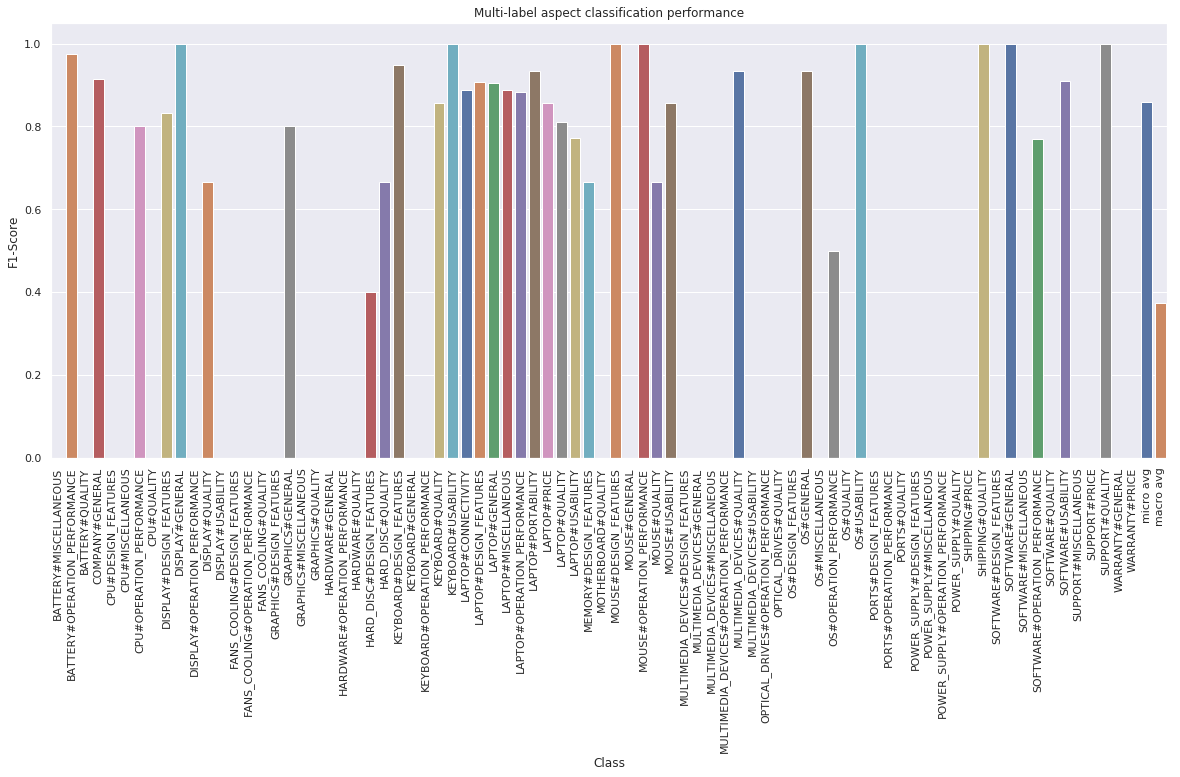

In [28]:
L16_f1s_aspect = []
for key in L16_aspect_report.keys():
    L16_f1s_aspect.append(L16_aspect_report.get(key).get('f1-score'))

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(20,8)})
sns.barplot(list(L16_aspect_report.keys())[:-2], L16_f1s_aspect[:-2], palette='deep')
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('Multi-label aspect classification performance')

[Text(0.0, 0, '0.00'),
 Text(0.9743589743589743, 1, '0.97'),
 Text(0.0, 2, '0.00'),
 Text(0.9142857142857143, 3, '0.91'),
 Text(0.0, 4, '0.00'),
 Text(0.0, 5, '0.00'),
 Text(0.8, 6, '0.80'),
 Text(0.0, 7, '0.00'),
 Text(0.8333333333333334, 8, '0.83'),
 Text(1.0, 9, '1.00'),
 Text(0.0, 10, '0.00'),
 Text(0.6666666666666666, 11, '0.67'),
 Text(0.0, 12, '0.00'),
 Text(0.0, 13, '0.00'),
 Text(0.0, 14, '0.00'),
 Text(0.0, 15, '0.00'),
 Text(0.0, 16, '0.00'),
 Text(0.8, 17, '0.80'),
 Text(0.0, 18, '0.00'),
 Text(0.0, 19, '0.00'),
 Text(0.0, 20, '0.00'),
 Text(0.0, 21, '0.00'),
 Text(0.0, 22, '0.00'),
 Text(0.4, 23, '0.40'),
 Text(0.6666666666666666, 24, '0.67'),
 Text(0.9473684210526316, 25, '0.95'),
 Text(0.0, 26, '0.00'),
 Text(0.0, 27, '0.00'),
 Text(0.8571428571428571, 28, '0.86'),
 Text(1.0, 29, '1.00'),
 Text(0.888888888888889, 30, '0.89'),
 Text(0.9074074074074073, 31, '0.91'),
 Text(0.9034749034749036, 32, '0.90'),
 Text(0.8888888888888888, 33, '0.89'),
 Text(0.8823529411764707, 34, 

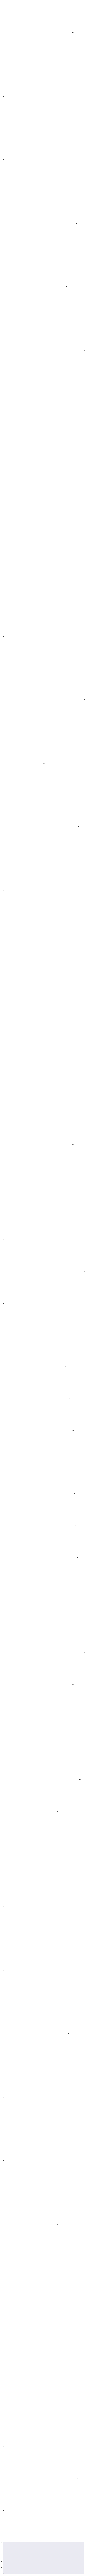

In [29]:
[plt.text(v, i, '{:.2f}'.format(v)) for i, v in enumerate(L16_f1s_aspect[:-2])]

##**XGBOOST Baseline Model for Polarity**

In [30]:
L16_polarity = MultiLabelBinarizer()
L16_polarity.fit(L16_train.polarity)
L16_polarity.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [31]:
y_L16_train_polarity = L16_polarity.transform(L16_train.polarity)
y_L16_test_polarity = L16_polarity.transform(L16_test.polarity)
y_L16_train_polarity[3]

array([0, 0, 1])

In [32]:
L16_xgb_polarity = OneVsRestClassifier(XGBClassifier(objective='binary:logistic', n_estimators=500 , max_depth=3,
                                                 learning_rate=0.05, n_jobs=24, verbosity=1, min_child_weight=50,
                                                 scale_pos_weight=6, base_score=0.3))
L16_xgb_polarity.fit(np.array(list(L16_train.embeddings)), y_L16_train_polarity)

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.3, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.05,
                                            max_delta_step=0, max_depth=3,
                                            min_child_weight=50, missing=None,
                                            n_estimators=500, n_jobs=24,
                                            nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=6,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=1),
        

In [0]:
L16_polarity_report = classification_report(y_L16_test_polarity, L16_xgb_polarity.predict(np.array(list(L16_test.embeddings))),
                            target_names=L16_polarity.classes_, output_dict=True)

Text(0.5, 1.0, 'Multi-label polarity classification performance')

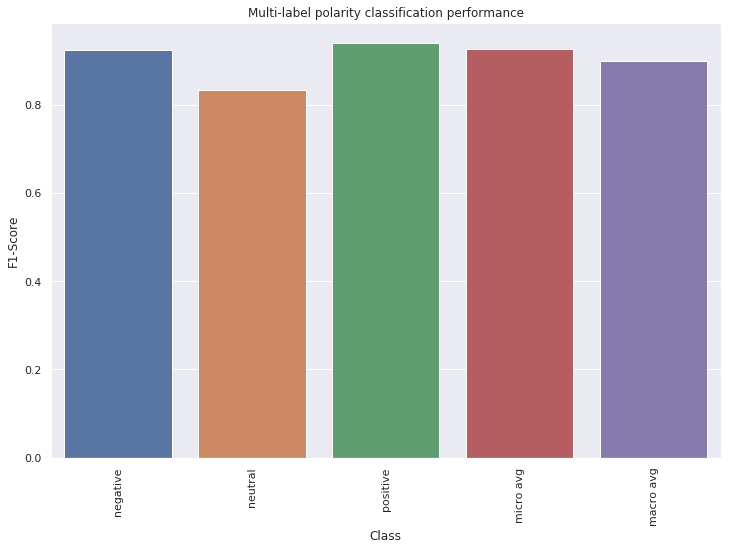

In [34]:
L16_f1s_polarity = []
for key in L16_polarity_report.keys():
    L16_f1s_polarity.append(L16_polarity_report.get(key).get('f1-score'))

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(list(L16_polarity_report.keys())[:-2], L16_f1s_polarity[:-2], palette='deep')
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('Multi-label polarity classification performance')

[Text(0.9239130434782609, 0, '0.92'),
 Text(0.8333333333333334, 1, '0.83'),
 Text(0.9389473684210526, 2, '0.94'),
 Text(0.9258028792912514, 3, '0.93'),
 Text(0.8987312484108823, 4, '0.90')]

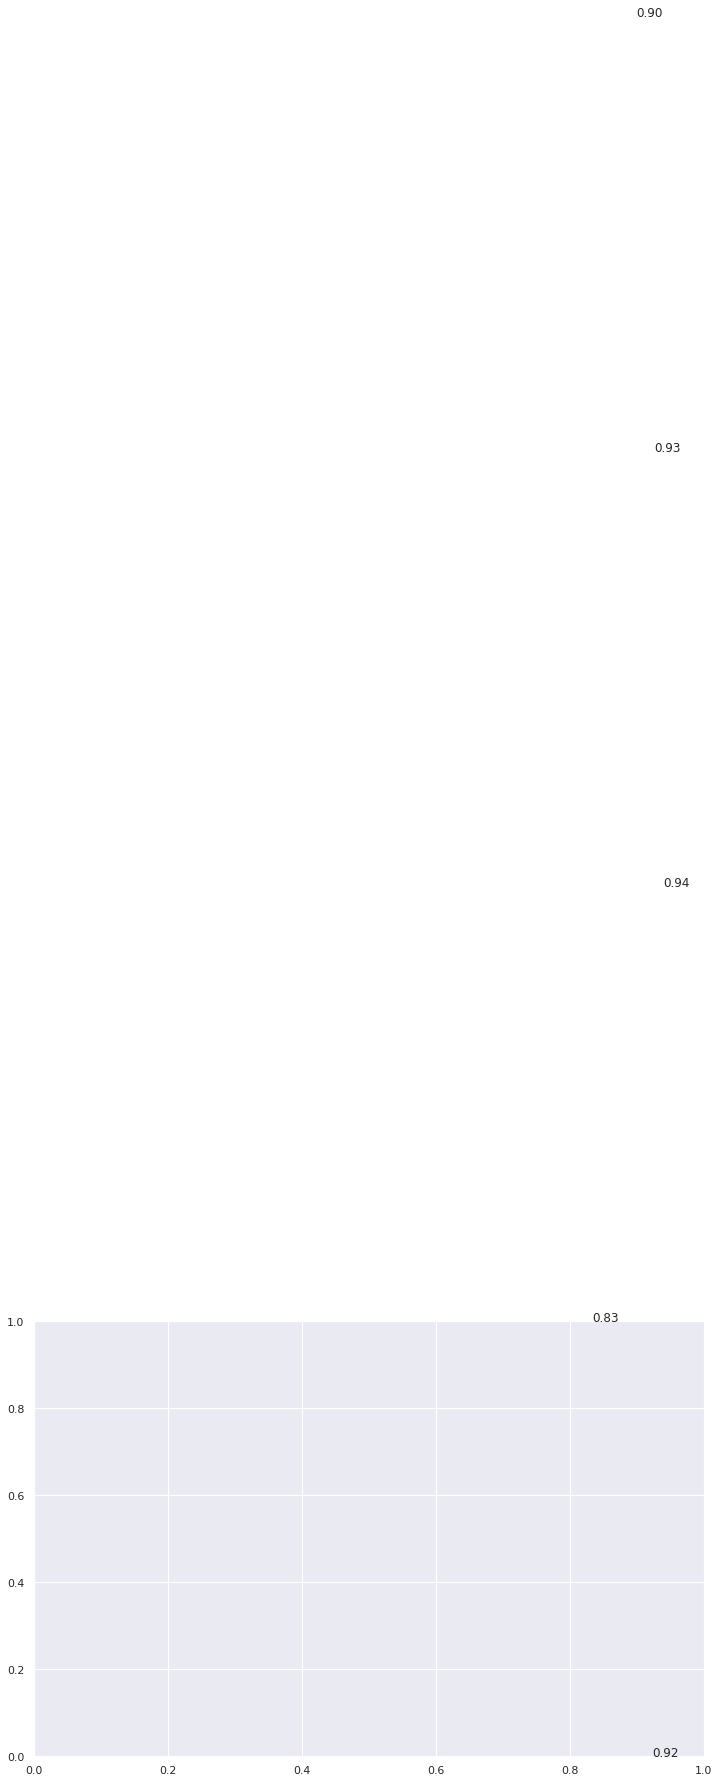

In [35]:
[plt.text(v, i, '{:.2f}'.format(v)) for i, v in enumerate(L16_f1s_polarity[:-2])]